# Test the new overture on Smallbone x van Heerden

In [1]:
from pyADAPT.optimize import Optimizer
from pyADAPT.examples import Smallbone2011
from van_heerden_preprocess import vhd
from pyADAPT.timeout import Timer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "grid"])

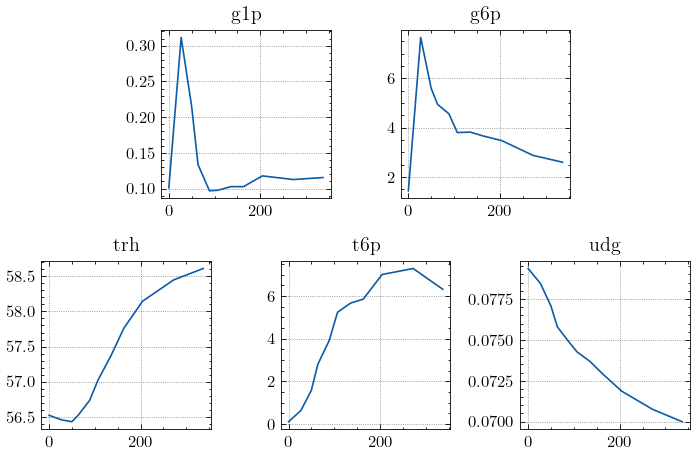

In [3]:
dataset = vhd(padding=False, smooth=True)
model = Smallbone2011()
fig = plt.figure(figsize=(6,4), dpi=120)
gs = fig.add_gridspec(ncols=6, nrows=4)
fig.add_subplot(gs[0:2, 1:3])
fig.add_subplot(gs[0:2, 3:5])
fig.add_subplot(gs[2:4, 0:2])
fig.add_subplot(gs[2:4, 2:4])
fig.add_subplot(gs[2:4, 4:6])
# print(fig.axes)
for i, s in enumerate(dataset):
    plt.sca(fig.axes[i])
    plt.plot(s.time, s.means)
    plt.title(s.name)
fig.tight_layout()

In [4]:
fit_params = list()
for id in model.parameters.index:
    if id[-5:] == "_Vmax":
        fit_params.append(id)
print(fit_params)

['pgi_Vmax', 'hxt_Vmax', 'hxk_Vmax', 'pgm_Vmax', 'tpp_Vmax', 'tps_Vmax', 'nth_Vmax', 'ugp_Vmax']


In [5]:
opt = Optimizer(model, dataset, fit_params)

In [6]:
opt.options['delta_t'] = 2
opt.set_timestep(opt.options['delta_t'])
opt.create_empty_trajectories(opt.options['n_ts'])
opt.options['timeout'] = 1000
opt.options['overture_variation'] = "lazy"

In [7]:
opt.options

{'optimizer': 'trf',
 'lambda_r': 1,
 'odesolver': 'BDF',
 'sseThres': 1000,
 'ss_time': 1000,
 'R': <function pyADAPT.regularization.default_regularization(params=None, parameter_trajectory=None, time_span=None, i_iter=None, i_ts=None, **kw)>,
 'interpolation': 'Hermite',
 'verbose': 1,
 'loglevel': 10,
 'overture_variation': 'lazy',
 'delta_t': 2,
 'n_core': 4,
 'n_iter': 5,
 'seed': 1,
 'initial_parameters': None,
 'weights': array([1., 1., 1., 1., 1.]),
 'timeout': 1000,
 'max_retry': 100,
 'logging_config_dict': {'version': 1,
  'formatters': {'brief': {'class': 'logging.Formatter',
    'format': '%(processName)-10s: %(message)s'},
   'detailed': {'class': 'logging.Formatter',
    'format': '%(asctime)s %(name)-15s %(levelname)-8s %(processName)-18s %(process)-5d %(message)s'}},
  'handlers': {'console': {'class': 'logging.StreamHandler',
    'formatter': 'brief',
    'level': 'INFO'},
   'file': {'class': 'logging.FileHandler',
    'filename': 'adapt_TP-Arch_2020-06-19_13.55.22.l

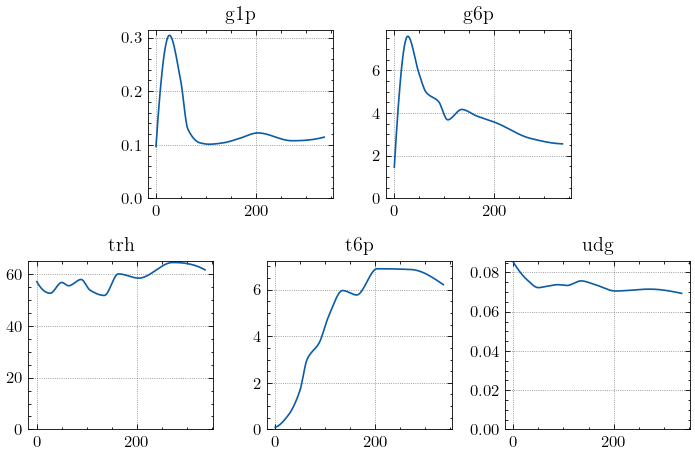

In [8]:
splines = opt.dataset.interpolate(opt.options['n_ts'])
fig = plt.figure(figsize=(6,4), dpi=120)
gs = fig.add_gridspec(ncols=6, nrows=4)
fig.add_subplot(gs[0:2, 1:3])
fig.add_subplot(gs[0:2, 3:5])
fig.add_subplot(gs[2:4, 0:2])
fig.add_subplot(gs[2:4, 2:4])
fig.add_subplot(gs[2:4, 4:6])
# print(fig.axes)
time = opt.time
for i, s in enumerate(dataset):
    plt.sca(fig.axes[i])
    plt.plot(time, splines[i,:,0])
    plt.title(s.name)
    plt.ylim(bottom=0)
fig.tight_layout()

In [9]:
def solve(time_points, params=None, x0=None):
    if params is None:
        params = opt.parameters['value']
    if x0 is None:
        x0 = opt.model.initial_states
    y = opt.model.compute_states(time_points=time_points,
                                 new_params=params,
                                 new_param_names=opt.parameter_names,
                                 x0=x0,
                                 odesolver="Radau")
    return y

The model was already in steady states using Smallbone's parameters and species concentrations

In [23]:
y[-1, :]

array([0.7       , 0.70000871, 0.70001558, ..., 0.70010804, 0.70010804,
       0.70010804])

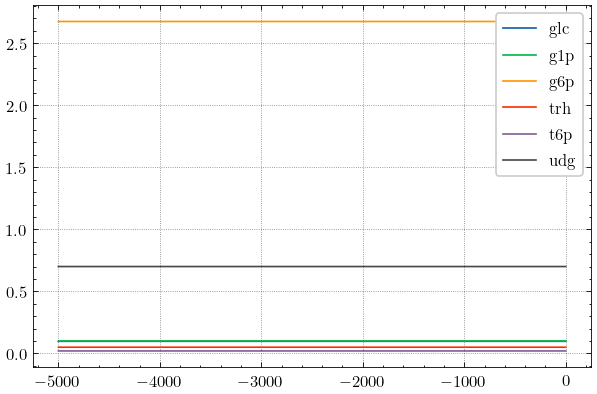

In [11]:
plt.figure(figsize=(6, 4), dpi=120)
y = solve(np.arange(-5000, 0, 0.2), params=opt.parameters['init'])
plt.plot(np.arange(-5000, 0, 0.2), y.T)
plt.legend(opt.model.state_order)

Now I want the model to have a different steady state concentration that is equal to the beginning of the splines from van Heerden's model. The resulted parameters will be used as the initial parameters of the simulation.

In [12]:
def init_fit(ss_time):
    # ss_time: how long the steady simulation should last before reaching steady states
    with Timer(f"ss_time={ss_time}"):
        opt.options['ss_time'] = ss_time
        time_points=np.linspace(- opt.options['ss_time'], 0, 1000)
        lsqres = opt.overture(0, splines)
    return lsqres, time_points

In [13]:
res10, time10 = init_fit(10000)

[ss_time=10000]
Elapsed: 69.86445736885071


In [14]:
print(np.c_[res10.x, opt.parameters['init'].values])

[[9.27883475e+02 1.07100000e+03]
 [2.24954786e-19 9.72400000e+01]
 [2.66975476e+02 2.89600000e+02]
 [3.50713799e+00 3.54500000e-01]
 [1.46157917e+01 6.50000000e+00]
 [7.24051713e+01 1.37100000e+00]
 [2.36564063e+00 1.52000000e+01]
 [5.12082813e+01 3.68200000e+01]]


In [15]:
splines[:,:,0].shape

(5, 169)

In [16]:
res10

 active_mask: array([ 0, -1,  0,  0,  0,  0,  0,  0])
        cost: 0.044262542063697057
         fun: array([-3.67794615e-09,  2.97531652e-01,  2.19878862e-08,  7.57641382e-09,
       -2.05598720e-09, -4.49418059e-13, -1.28785871e-14, -1.07736042e-12,
        2.65851869e-08, -2.35367281e-14,  1.37667655e-14])
        grad: array([-9.55768870e-12,  6.90843442e-04, -1.12110371e-10,  7.95148455e-08,
       -3.49470976e-09,  2.28961152e-09, -2.65660050e-07,  3.50444154e-09])
         jac: array([[-2.07281055e-11,  7.43558085e-04, -1.44082647e-10,
         3.20158810e-01, -3.94777108e-09, -7.14278164e-03,
        -8.94328278e-08, -1.18275139e-02],
       [-3.21186045e-11,  2.32191384e-03, -3.76749355e-10,
         7.11675592e-08, -9.68548502e-09,  2.36672810e-09,
        -2.64557837e-07,  3.12815583e-09],
       [-7.27429903e-08,  2.59246795e-02, -8.14878265e-07,
         2.66646482e+00, -1.98716534e-05,  6.84580291e-02,
        -8.50228324e+00,  1.13356559e-01],
       [-5.52202556e-11,  

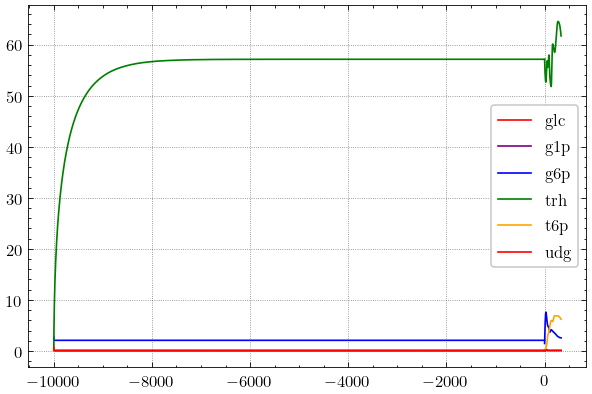

In [42]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), dpi=120)

colors = ['red', 'purple', 'blue', 'green', 'orange', 'red']
i = 2
# plt.sca(axes[i])
t1 = np.arange(-10000, 0, 0.2)
y1 = solve(t1, params=res10.x)

for j in range(6):
    axes.plot(t1, y1[j, :], color=colors[j], label=opt.model.state_order[j])
    if j < 5:
        axes.plot(opt.time, splines[j,:,0], color=colors[j+1])
# plt.xlim(left=-100, right=340)
# plt.ylim(bottom=0, top=10)        
# plt.savefig('init2.png')
axes.legend()
#     plt.ylim(bottom=0, top=4)
plt.savefig('state.png')

In [40]:
y1[:, -1]

array([6.95160478e-03, 9.68449720e-02, 2.08333336e+00, 5.71463780e+01,
       9.08820847e-02, 8.51492627e-02])

In [41]:
splines[:,-1, 0]

array([ 0.11434042,  2.55506118, 61.71688169,  6.21594575,  0.06935041])

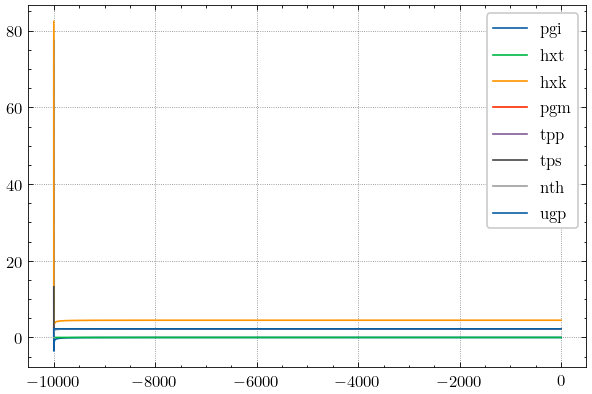

In [19]:
fig2, axes2 = plt.subplots(figsize=(6, 4), dpi=120)

f1 = list(map(lambda t, x: opt.model.fluxes(t, x, opt.model.parameters["value"]), t1, y1.T))

axes2.plot(t1, f1)
axes2.legend(opt.model.flux_order)

In [26]:
fig2.savefig('fluxes.png')

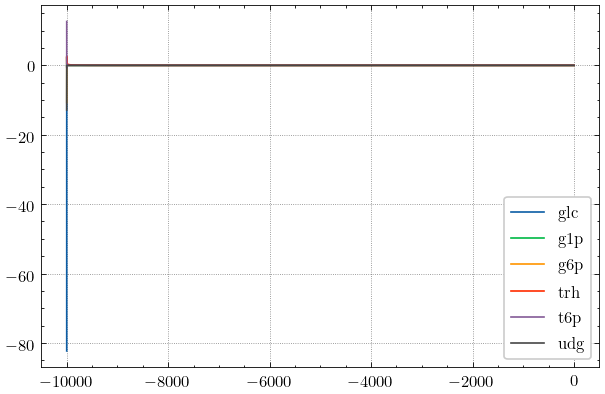

In [28]:
fig3, axes3 = plt.subplots(figsize=(6,4), dpi=120)

dy = list(map(lambda t, x: opt.model.state_ode(t, x, opt.model.parameters['value']), t1, y1.T))

axes3.plot(t1, dy)
axes3.legend(opt.model.state_order)

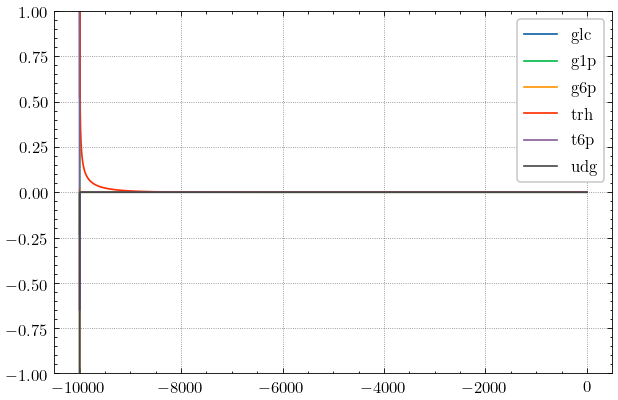

In [36]:
fig, axes = plt.subplots(figsize=(6, 4), dpi=120)

plt.plot(t1, dy)
plt.legend(opt.model.state_order)
plt.ylim(-1, 1)
plt.savefig("ode.png")

In [80]:
print(y1[:,-1])
print(np.r_[0, splines[:,0, 0]])

[3.30337363e-03 1.02693267e-01 2.08333328e+00 5.69528492e+01
 1.03602578e-01 7.55254092e-02]
[ 0.          0.10269327  1.34897937 56.9530802   0.10360258  0.07552542]


(0.0, 10.0)

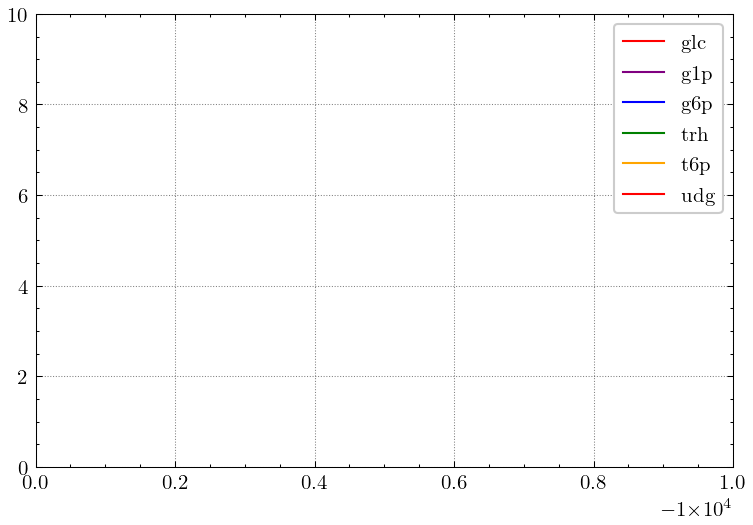

In [75]:
colors = ['red', 'purple', 'blue', 'green', 'orange', 'red']
# plt.sca(axes[i])
fig = plt.figure(figsize=(6, 4), dpi=150)
t1 = np.arange(-opt.options["ss_time"], 0, 0.002)
y1 = solve(t1, params=opt.parameter_trajectory[0,:])
for j in range(6):
    plt.plot(t1, y1[j, :], color=colors[j], label=opt.model.state_order[j])
    if j < 5:
        plt.plot(opt.time, splines[j,:,0], color=colors[j+1])
plt.legend()
plt.xlim(left=-10000, right=-9999)
plt.ylim(0, 10)

In [40]:
opt.options['lambda_r'] = 100
opt.options['ss_time'] = 10000
opt.options['overture_variation'] = "default"
opt.overture(0, splines)

 active_mask: array([ 0, -1,  0,  0,  0,  0,  0,  0])
        cost: 0.05445512260568396
         fun: array([-1.57346427e-09,  3.30015522e-01,  8.70877980e-06, -3.33021113e-09,
       -2.21229069e-09,  9.79828733e-06, -2.04813944e-12, -2.16150120e-09,
       -5.44421879e-06, -1.94066985e-12,  2.28705943e-12])
        grad: array([-2.57451469e-11,  5.57438587e-04, -1.85982200e-10,  2.18096897e-05,
       -3.82588866e-09,  5.32790989e-07, -6.87879199e-05,  9.30460849e-07])
         jac: array([[-7.98586685e-12,  5.60478827e-04, -1.67898597e-09,
         2.98550265e-01,  1.26547175e-09, -6.43071622e-03,
         7.59327704e-08, -1.12370580e-02],
       [ 2.45806864e-11,  1.68874860e-03,  1.72265279e-10,
         3.36100418e-08,  3.16481089e-09,  7.43329872e-10,
        -1.15400660e-07,  1.99196576e-09],
       [-2.87463517e-06,  1.57657221e-02, -2.06474465e-05,
         2.50230701e+00, -4.35809304e-04,  6.11261263e-02,
        -7.89141572e+00,  1.06751196e-01],
       [ 0.00000000e+00,  1

In [30]:
opt.options['weight'] = np.ones(5)
for i_ts in range(1, opt.options["n_ts"]):
    print(i_ts, end="\t")
    (
        opt.parameter_trajectory[i_ts, :],
        opt.state_trajectory[i_ts, :],
        opt.flux_trajectory[i_ts, :],
    ) = opt.fit_timestep(
        initial_guess=opt.parameter_trajectory[i_ts - 1, :],
        begin_states=opt.state_trajectory[i_ts - 1, :],
        end_data=splines[:, i_ts, :],
        i_iter=0,
        i_ts=i_ts,
    )

1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	

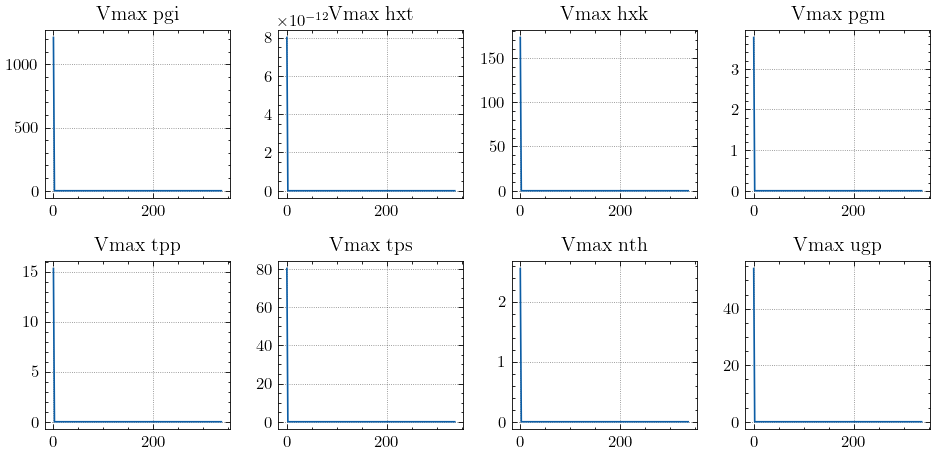

In [41]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(8, 4), dpi=120)

for i, a in enumerate(axes.flatten()):
    plt.sca(a)
    plt.plot(opt.time, opt.parameter_trajectory[:,i])
    plt.title(" ".join(opt.parameter_names[i].split("_")[::-1]))
fig.tight_layout()

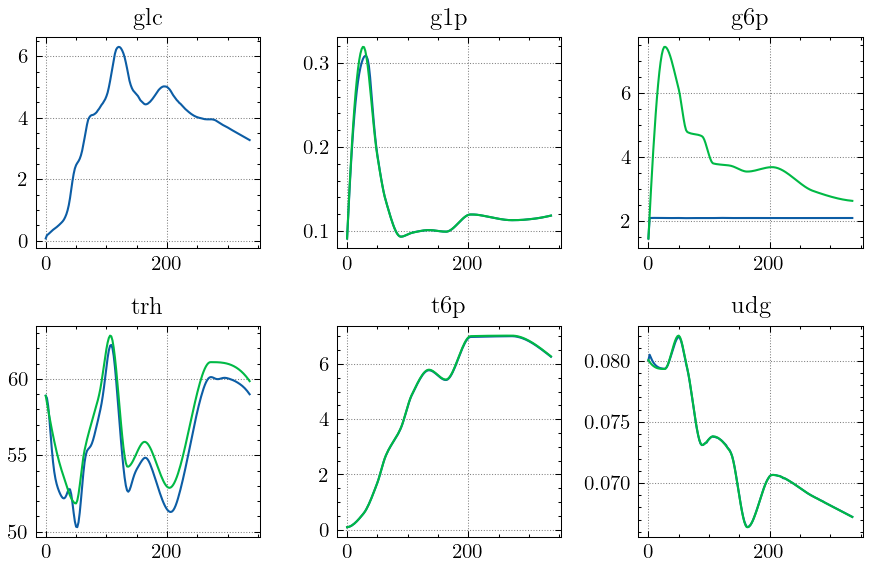

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(6, 4), dpi=150)

for i, a in enumerate(axes.flatten()):
    plt.sca(a)
    plt.plot(opt.time, opt.state_trajectory[:, i])
    plt.title(opt.model.state_order[i])
    if i > 0:
        plt.plot(opt.time, splines[i-1,:,0])
fig.tight_layout()

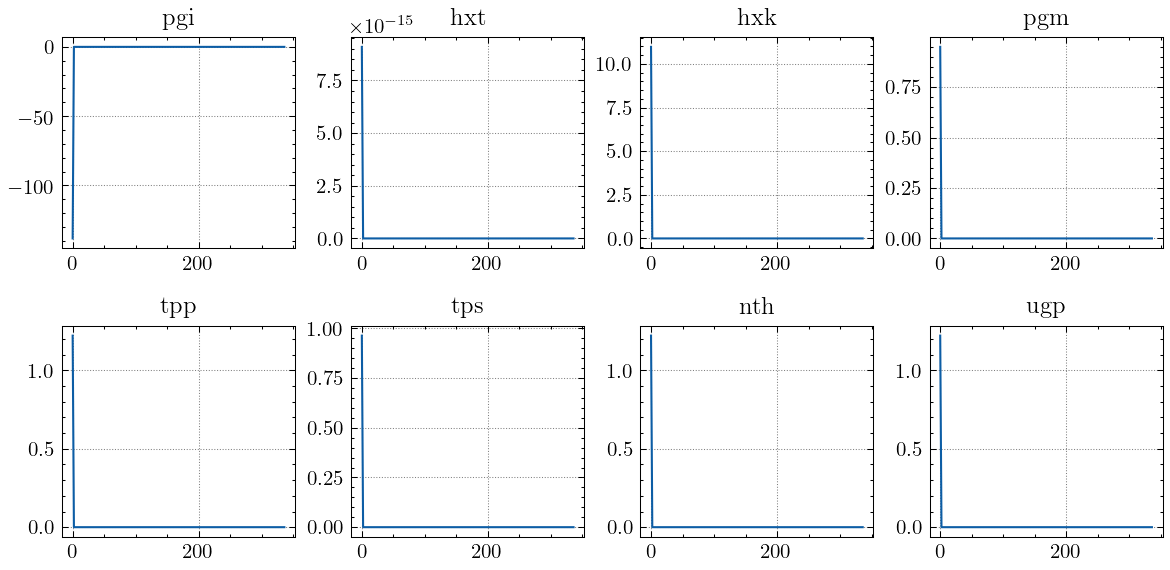

In [57]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(8, 4), dpi=150)
for i,a in enumerate(axes.flatten()):
    plt.sca(a)
    plt.plot(opt.time, opt.flux_trajectory[:,i])
    plt.title(opt.model.flux_order[i])
fig.tight_layout()

In [39]:
model.initial_states, opt.state_mask, model.state_order

(array([0.09675, 0.1    , 2.675  , 0.05   , 0.02   , 0.7    ]),
 [False, True, True, True, True, True],
 ['glc', 'g1p', 'g6p', 'trh', 't6p', 'udg'])

simulate the model with the resulted parameters and the initial values in the spline

In [29]:
opt.parameters

,name,value,vary,lb,ub,init
pgi_Vmax,pgi_Vmax,4768.148165,False,0.0,inf,1071.0000
hxt_Vmax,hxt_Vmax,0.000392,False,0.0,inf,97.2400
hxk_Vmax,hxk_Vmax,222.880102,False,0.0,inf,289.6000
pgm_Vmax,pgm_Vmax,1.862282,False,0.0,inf,0.3545
tpp_Vmax,tpp_Vmax,7.916872,False,0.0,inf,6.5000
tps_Vmax,tps_Vmax,35.750236,False,0.0,inf,1.3710
nth_Vmax,nth_Vmax,1.347954,False,0.0,inf,15.2000
ugp_Vmax,ugp_Vmax,36.986983,False,0.0,inf,36.8200


In [49]:
opt.parameter_trajectory = np.zeros((n_ts, len(opt.parameter_names)))
opt.state_trajectory = np.zeros((n_ts, len(opt.model.state_order)))
opt.flux_trajectory = np.zeros((n_ts, len(opt.model.flux_order)))

In [50]:
opt.time = np.arange(
        opt.dataset.begin_time, opt.dataset.end_time, opt.options["delta_t"]
    )

In [52]:
y = opt.model.compute_states(
    new_params=opt.parameters.value,
    new_param_names=["k1"],
    x0=splines[:,0,0],
    time_points=np.linspace(-100, 0, 1000))
dy = opt.model.state_ode(0, y[:, -1], opt.model.parameters["value"])

In [53]:
opt.model.initial_states

array([0.78160408, 0.12261792, 0.49338649, 0.43290209])

In [62]:
opt2 = Optimizer(smallbone, vhd_dataset, ['hxt_Vmax', 'pgi_Vmax', 'hxk_Vmax', 'pgm_Vmax', 'nth_Vmax'])

In [63]:
opt2.time = np.arange(
            opt2.dataset.begin_time, opt2.dataset.end_time, opt.options["delta_t"]
        )
n_ts = len(opt2.time)
opt2.create_empty_trajectories(n_ts)

In [ ]:
opt2.options['odesolver'] = "LSODA"
spl2 = opt2.dataset.interpolate(n_ts)
opt2.initialize_trajectories(0, spl2)

In [40]:
opt2.parameter_trajectory[0, :]

array([0.20403237])

In [42]:
opt2.parameters

,name,value,vary,lb,ub,init
hxt_Vmax,hxt_Vmax,7.302713,False,0.0,inf,97.24
